# Alen Omarov

## RFM Analysis in Python - Customer Segmentation

## Research question/interests
The goal of this analysis is to identify customer segments for UK based retail company using RFM analysis and to understand how those groups differ from each other and try to predict customer lifetime value for the company.

![Customer Segmentation](../images/customer_segmentation.png)

---

Customer segmentation is an effective tool for businesses to closely align their strategy and tactics with, and better target, their customers. Every customer is different and every customer journey is different so a single approach often isn’t going to work for all. This is where customer segmentation becomes a valuable process. Customer segmentation is the process by which you divide your customers into segments up based on common characteristics – such as demographics or behaviors, so you can market to those customers more effectively.

RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

---

## Imports

In [225]:
import pandas as pd
import datetime as dt
import seaborn as sns
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from plotly.offline import  init_notebook_mode
init_notebook_mode(connected=True)
palette = 'Set2'

---

## Loading the Data

In [226]:
#This time i'm using data from the processed folder
data = pd.read_csv("../data/processed/new_data.csv")

In [227]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


---

## Exploring our Data

### Variable Description

- InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product code that consists 5 digits.
- Description: Product name.
- Quantity: The quantities of each product per transaction.
- InvoiceDate: Represents the day and time when each transaction was generated.
- UnitPrice: Product price per unit.
- CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
- Country: Name of the country where each customer resides.

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406223 entries, 0 to 406222
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406223 non-null  object 
 1   StockCode    406223 non-null  object 
 2   Description  406223 non-null  object 
 3   Quantity     406223 non-null  int64  
 4   InvoiceDate  406223 non-null  object 
 5   UnitPrice    406223 non-null  float64
 6   CustomerID   406223 non-null  float64
 7   Country      406223 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.8+ MB


In [229]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406223.000000,406223.000000,406223.000000
mean,12.063138,3.463125,15287.550183
std,248.878146,69.366810,1713.683746
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


- As we can see, there are outliers in Quantity and UnitPrice that have to be handled.
- There are negative values in UnitPrice and Quantity because of cancelled orders.
- To get Total Price we should multiply these two columns

### Data Cleaning

Now I'm going to clean this data even further for my own purposes.

In [230]:
def outlier(data, variable, q1 = 0.25, q3 = 0.75):
    """
    Remove outliers from dataset based on q1 and q2

        Parameters
    ----------
    data : pandas DataFrame
        dataframe to clean

    variable: column of pandas Dataframe
        which column to clean

    q1: int
        first quartile

    q2: int
        second quartile

    Returns
    -------
    pandas DataFrame
        Cleaned dataset
    """
    df = data.copy()
    quartile1 = df[variable].quantile(q1)
    quartile3 = df[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

    return df


def cleaning(data):
    """
    Remove cancelled Orders & Quantity from dataset, calculate Total Price, Replace Outliers

    Parameters
    ----------
    data : pandas DataFrame
        dataframe to clean

    Returns
    -------
    pandas DataFrame
        Cleaned dataset
"""
    df = data.copy()

    df = df.dropna()
    #Dealing with cancelled orders
    df = df[~df['InvoiceNo'].str.contains('C', na = False)]
    df = df[df['Quantity'] > 0]


    #Replacing Outliers
    outlier(df, "Quantity", q1 = 0.01, q3 = 0.99)
    outlier(df, "UnitPrice", q1 = 0.01, q3 = 0.99)

    #Calculating Total Price
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

    return df

In [231]:
data = cleaning(data)
data[['Quantity', 'UnitPrice', 'TotalPrice']].describe()
data[['Quantity', 'UnitPrice', 'TotalPrice']].sort_values(by = 'TotalPrice', ascending = False).head()

,Quantity,UnitPrice,TotalPrice
405744,80995,2.08,168469.60
38093,74215,1.04,77183.60
158996,60,649.50,38970.00
121203,1,8142.75,8142.75
254316,1412,5.06,7144.72


---

## RFM Analysis

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.
- Recency (R): Who have purchased recently? Number of days since last purchase
- Frequency (F): Who has purchased frequently? The total number of purchases
- Monetary Value(M): Who has high purchase amount? The total money customer spent

### Recency

To calculate ours recency scores, we need to find the latest date in this dataset and take it as a point from which we will calculate how many days ago was the customer's last purchase.

In [232]:
#create a new column called date which contains the date of invoice only
#because InvoiceDate in String format, but we need it in the date format
data['date'] = pd.DatetimeIndex(data['InvoiceDate']).date
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01


In [233]:
#last date available in our dataset
print(data['date'].max())

2011-12-09


The latest date is 2011-12-09

In [234]:
latest = dt.date(2011, 12, 9)
print(latest)

2011-12-09


In [235]:
#I'm grouping by customerID and check last date of purchase
recency = data.groupby(by='CustomerID', as_index=False)['date'].max()
recency.columns = ['CustomerID','LastPurchase']
recency.head()

,CustomerID,LastPurchase
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [236]:
#calculate recency
recency['Recency'] = recency['LastPurchase'].apply(lambda x: (latest - x).days)
recency.drop('LastPurchase',axis=1,inplace=True)
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


### Frequency

Frequency helps us to know how many times a customer purchased from the store. We need to check how many invoices are registered by the same customer.

In [237]:
# First of all we will drop all duplicates
df_freq = data.copy()
df_freq.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency = df_freq.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


### Monetary

Monetary attribute answers the question: How much money did the customer spent over time? To do that, first, we will create a new column total cost to have the total price per invoice.

In [238]:
monetary = data.groupby(by='CustomerID',as_index=False).agg({'TotalPrice': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4290.20
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Merging to get RFM Table

In [239]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,7,4290.20
2,12348.0,75,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,310,1,334.40


### RFM Scores

In [240]:
def get_rfm_scores(data):
    """
    Calculate RFM Scores based on values of Recency, Frequency, Monetary

    Parameters
    ----------
    data : pandas DataFrame
        dataframe on which we want to calculate RFM Scores

    Returns
    -------
    pandas DataFrame
        dataframe with RFM Scores


    """

    df = data.copy()
    df['recency_score'] = pd.qcut(df['Recency'],5,labels = [5, 4, 3, 2, 1])
    df['frequency_score'] = pd.qcut(df['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    df['monetary_score'] = pd.qcut(df['Monetary'], 5, labels = [1, 2, 3, 4, 5])
    df['RFM_SCORE'] = (df['recency_score'].astype(str) + df['frequency_score'].astype(str))

    return df

rfm = get_rfm_scores(rfm)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346.0,325,1,77183.60,1,1,5,11
1,12347.0,2,7,4290.20,5,5,5,55
2,12348.0,75,4,1797.24,2,4,4,24
3,12349.0,18,1,1757.55,4,1,4,41
4,12350.0,310,1,334.40,1,1,2,11


In [241]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,325,1,77183.60,1,1,5,11,hibernating
1,12347.0,2,7,4290.20,5,5,5,55,champions
2,12348.0,75,4,1797.24,2,4,4,24,at_Risk
3,12349.0,18,1,1757.55,4,1,4,41,promising
4,12350.0,310,1,334.40,1,1,2,11,hibernating
5,12352.0,36,8,2506.04,3,5,5,35,loyal_customers
6,12353.0,204,1,89.00,1,1,1,11,hibernating
7,12354.0,232,1,1079.40,1,1,4,11,hibernating
8,12355.0,214,1,459.40,1,1,2,11,hibernating
9,12356.0,22,3,2811.43,4,3,5,43,potential_loyalists


| Id  | Segment                   | Description                                                                                                                                                                           | R   | F   | M   |
|-----|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----|-----|-----|
| 1   | Champions                 | Reward these users. They promote your products and they can be early adopters for your new launches                                                                                   | 4-5 | 4-5 | 4-5 |
| 2   | Loyal Customers           | These users are responsive to your promotions. Suggest higher-value products to them. Also, leverage them for reviews                                                                 | 4-5 | 1-5 | 1-5 |
| 3   | Potential Loyalist        | Engage them with long-term offers like loyalty programs or membership rewards. Suggest other categories of products to them                                                           | 3-5 | 1-4 | 1-4 |
| 4   | New Customers             | For new users, make their onboarding experience smooth and provide assistance when needed                                                                                             | 4-5 | 0-1 | 0-1 |
| 5   | Promising                 | Convert them into loyal customers by creating brand awareness and giving free trials                                                                                                  | 3-4 | 0-1 | 0-1 |
| 6   | Needs Attention           | You need to bring back these customers. Provide limited period offers and recommend products based on their purchase history (Above average recency, frequency & monetary values)     | 2-3 | 2-3 | 2-3 |
| 7   | About To Sleep            | Swoop in before you lose them. Recommend popular products and provide membership discounts. Reactivate them as soon as possible (Below average recency, frequency & monetary values)	 | 2-3 | 0-2 | 0-2 |
| 8   | At Risk (Price Sensitive) | These are users looking for the best deal. Recommend highest-rated products and send discount communication (Spent big money, purchased often but long time ago)                      | 0-3 | 1-5 | 1-5 |
| 9   | Can`t Lose Them           | Listen to their feedback, suggest newer products and make them stick to your platform (Made big purchases and often, but long time ago)                                               | 0-1 | 4-5 | 4-5 |
| 10  | Hibernating               | Recommend relevant products from other categories and provide personalized offers (Low spenders, low frequency, purchased long time ago)                                              | 0-2 | 0-2 | 0-2 |

![customer_segmentation](../images/Recency.png)

---

## Segment Analysis

Now I'm going to check mean, std, and max for three scores(Recency, Monetary, Frequency) across all segments.

In [242]:
rfm[['Recency','Monetary','Frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

Recency                           Monetary             \
                           std  max min        mean           std        max   
segment                                                                        
about_to_sleep       10.943474   71  33   52.312500    533.269005    6207.67   
at_Risk              68.618828  373  72  152.785835   2561.959082   44534.30   
cant_loose           65.250378  372  72  131.968254   2084.963054   10254.18   
champions             3.683300   12   0    5.361769  20334.484637  280065.17   
hibernating          92.013560  373  72  216.605042   2419.680843   77183.60   
loyal_customers      15.577050   71  14   32.608059   6001.962699  124844.93   
need_attention       11.552074   71  33   51.427807   1102.392867   12601.83   
new_customers         3.902112   12   0    6.428571    570.778807    3861.00   
potential_loyalists   9.338808   32   0   16.398760   7656.326604  168472.50   
promising             5.238115   32  14   22.421053    241.199688    1757.55   

                                          Frequency                      
                        min         mean        std  max min       mean  
segment                                                                  
about_to_sleep         6.20   471.007443   0.368913    2   1   1.161932  
at_Risk               52.00  1082.825347   0.954415    6   2   2.878583  
cant_loose            70.02  2792.147937   4.289630   34   6   8.380952  
champions            201.12  6851.544692  16.477052  210   3  12.415482  
hibernating            3.75   487.986585   0.302492    2   1   1.101774  
loyal_customers       36.56  2860.033017   4.545669   63   3   6.479853  
need_attention         6.90   895.799251   0.470081    3   2   2.326203  
new_customers         89.94   387.348571   0.000000    1   1   1.000000  
potential_loyalists   20.80  1040.163326   0.651401    3   1   2.010331  
promising              0.00   290.496316   0.000000    1   1   1.000000

To understand percentage distribution of all segments, I'll use count-plot.

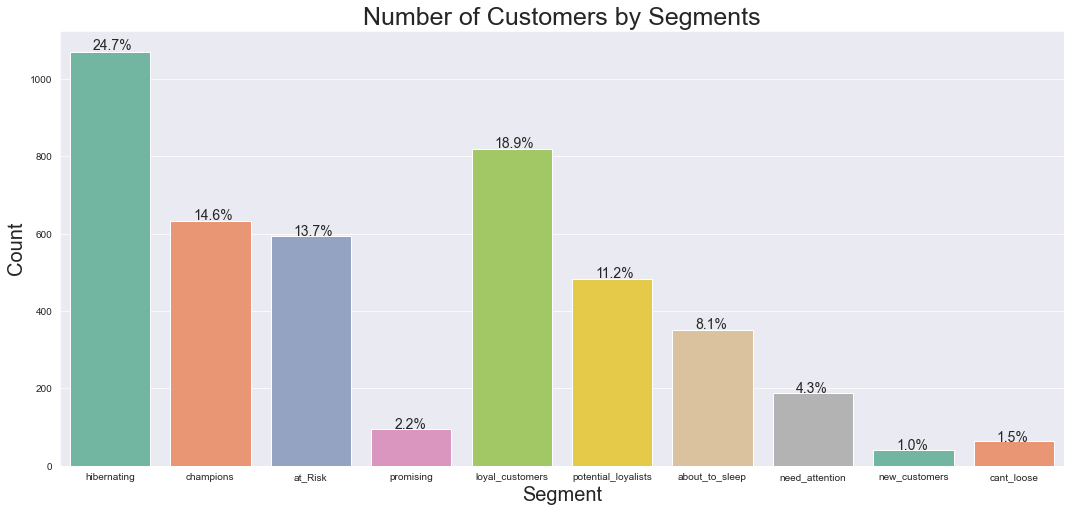

In [243]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 25)
plt.xlabel('Segment', size = 20)
plt.ylabel('Count', size = 20)
plt.show()

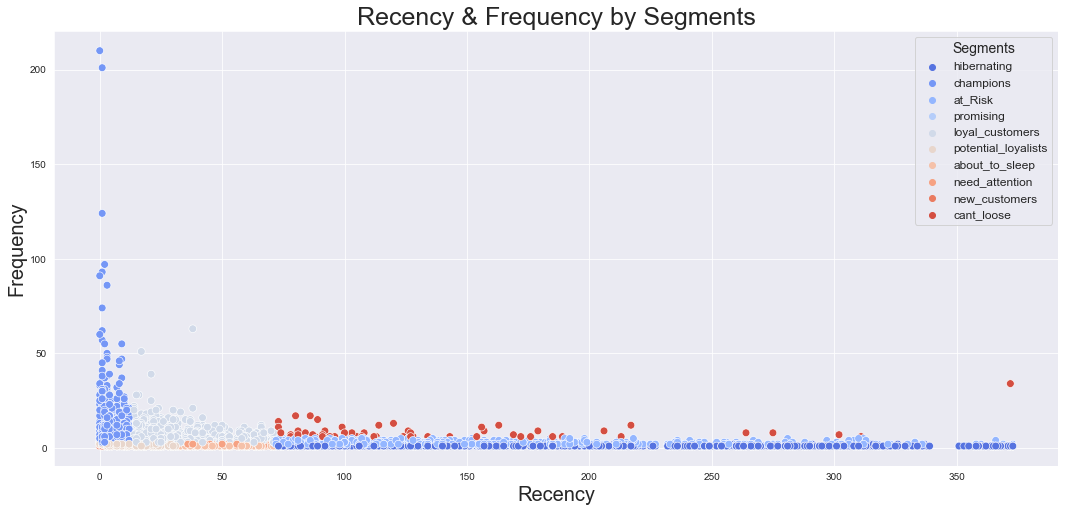

In [256]:
plt.figure(figsize = (18, 8))
sns.scatterplot(data = rfm,
                x = 'Recency',
                y = 'Frequency',
                hue ='segment',
                palette = palette,
                s = 60)
plt.title('Recency & Frequency by Segments', size = 25)
plt.xlabel('Recency', size = 20)
plt.ylabel('Frequency', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.legend(loc = 'best', fontsize = 12,
           title = 'Segments',title_fontsize=14)
plt.show()


### Distribution of metrics

All distributions is right-skewed, showing that the majority of customers made a purchase in the recent past, on small price, and it was their 3 purchase. It has a long tail containing single customers who made their order long time ago, with big prices, and a lot of purchases.

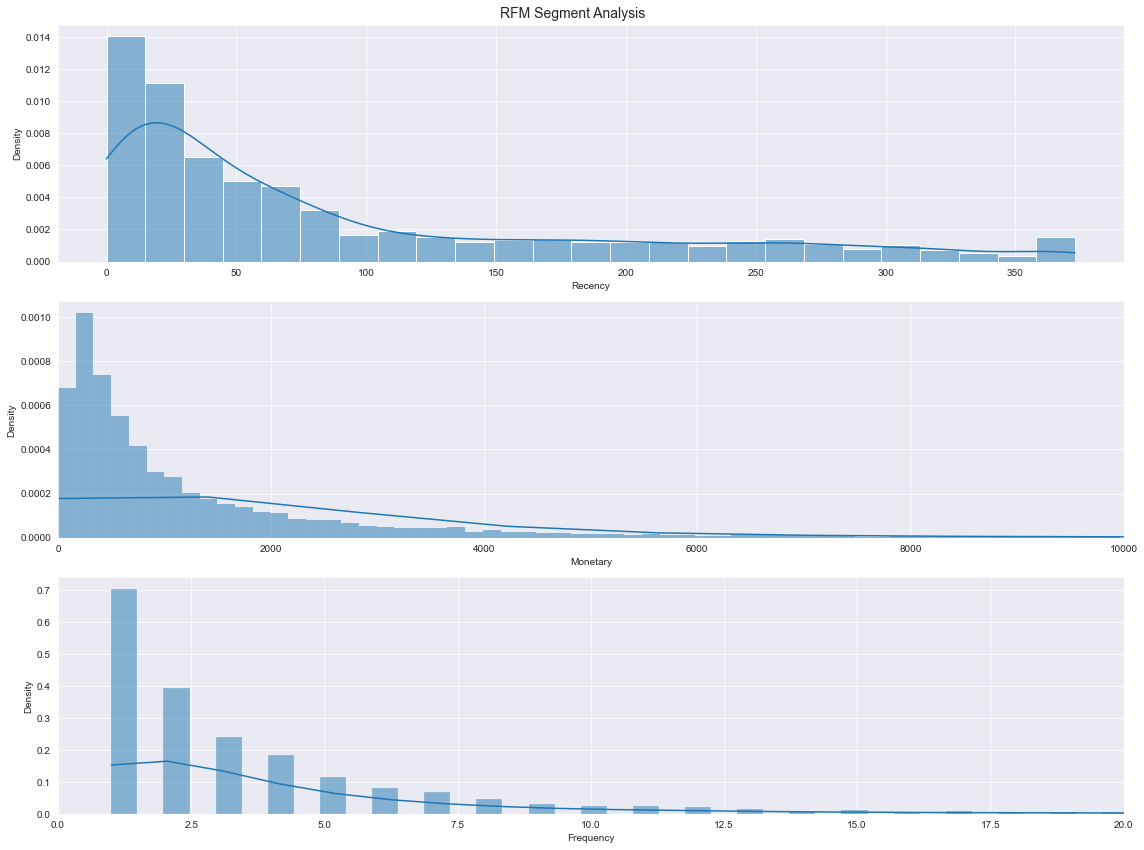

In [274]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['Recency', 'Monetary', 'Frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                x = feature_list[idx], kde = True, stat="density")
    if idx == 1:
        axes[idx].set_xlim([0, 10000])
    if idx == 2:
        axes[idx].set_xlim([0, 20])
plt.tight_layout()
plt.show()

In [246]:
agg_dict2 = {
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum'
}

df_analysis = rfm.groupby('segment').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'segment': 'label', 'CustomerID': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']
df_analysis

,label,count,Recency,Frequency,Monetary,count_share,monetary_share
0,champions,633,5.361769,12.415482,6851.544692,0.145886,0.487270
1,new_customers,42,6.428571,1.000000,387.348571,0.009680,0.001828
2,potential_loyalists,484,16.398760,2.010331,1040.163326,0.111546,0.056562
3,promising,95,22.421053,1.000000,290.496316,0.021894,0.003101
4,loyal_customers,819,32.608059,6.479853,2860.033017,0.188753,0.263168
5,need_attention,187,51.427807,2.326203,895.799251,0.043097,0.018820
6,about_to_sleep,352,52.312500,1.161932,471.007443,0.081125,0.018627
7,cant_loose,63,131.968254,8.380952,2792.147937,0.014519,0.019763
8,at_Risk,593,152.785835,2.878583,1082.825347,0.136667,0.072142
9,hibernating,1071,216.605042,1.101774,487.986585,0.246831,0.058719


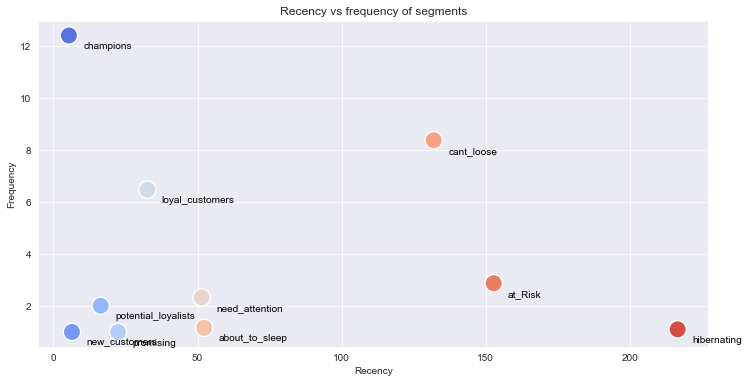

In [277]:
palette = sns.color_palette("coolwarm", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='Recency', y='Frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
    plot.text(df_analysis['Recency'][i]+5,
              df_analysis['Frequency'][i]-0.5,
              df_analysis['label'][i],
              horizontalalignment='left',
              size='medium', color='black')

ax.set_title('Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()

As expected, scatterplot visualizes the set of rules applied to generate RFM segments. 'Champions' and 'loyal customers' are the ones who buy the most often and who made their last order recently. 'New customers' and 'promising' made purchases not long time ago but they are not frequent buyers yet. And 'hibernating' customers are the ones with the lowest recency and frequency scores. "Can't lose" are customers who made purchase long time ago, but made a lot of purchases.

---

## LifeTime Value of Customers

Customer lifetime value is how much money a customer will bring your brand throughout their entire time as a paying customer

In [248]:
cltv_df = data.groupby('CustomerID').agg({'date': [lambda x: (x.max() - x.min()).days,
                                                        lambda x: (latest - x.min()).days],
                                        'InvoiceNo': 'nunique',
                                        'TotalPrice': 'sum'})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['Recency', 'T', 'Frequency', 'Monetary']
cltv_df.head()

,Recency,T,Frequency,Monetary
CustomerID,,,,
12346.0,0,325,1,77183.60
12347.0,365,367,7,4290.20
12348.0,283,358,4,1797.24
12349.0,0,18,1,1757.55
12350.0,0,310,1,334.40


In [249]:
#Average Order Value
cltv_df["Monetary"] = cltv_df["Monetary"] / cltv_df["Frequency"]

#Recency & Tenure
cltv_df["Recency"] = cltv_df["Recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['Frequency'] > 1)]

Beta Geometric / Negative Binomial Distribution models assume that the number of transactions made by each customer follows a Poisson process with a heterogeneity in transaction rates across customers following a gamma distribution. These assumptions give us a Negative binomial distribution (NBD) for modeling the number of transactions made by the customer while he is alive. We can build BG/NBD model by using BetaGeoFitter and lifetimes packages.

In [250]:
BGF = BetaGeoFitter(penalizer_coef = 0.001) #avoid overfitting

BGF.fit(cltv_df['Frequency'],
        cltv_df['Recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.11, alpha: 11.37, b: 2.46, r: 2.18>

### Top 10 Expected Number of Transaction (1 Week)

In [251]:
BGF.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['Frequency'],
                                                        cltv_df['Recency'],
                                                        cltv_df['T']
                                                        ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index()

,CustomerID,Expected Number of Transactions
0,12748.0,3.277040
1,14911.0,3.136970
2,17841.0,1.947509
3,13089.0,1.543490
4,14606.0,1.468614
5,15311.0,1.438119
6,12971.0,1.362459
7,14646.0,1.226521
8,13408.0,0.989706
9,18102.0,0.971942


### Top 10 Expected Number of Transaction (1 Month)

In [252]:
BGF.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['Frequency'],
                                                        cltv_df['Recency'],
                                                        cltv_df['T']
                                                        ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index()

,CustomerID,Expected Number of Transactions
0,12748.0,13.074660
1,14911.0,12.515809
2,17841.0,7.770091
3,13089.0,6.157995
4,14606.0,5.859393
5,15311.0,5.737721
6,12971.0,5.435822
7,14646.0,4.892949
8,13408.0,3.948644
9,18102.0,3.877634


### Frequency of Repeat Transactions

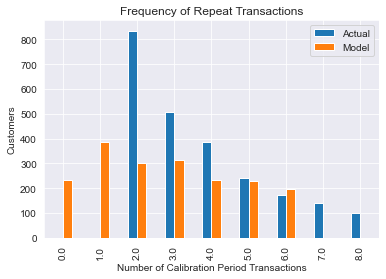

In [253]:
#Plot a figure with period actual and predicted transactions.
plot_period_transactions(BGF,
                         max_frequency = 7)
plt.show()

We Separated all the customers into 10 informative categories based on their recency, frequency and monetary. And determined how we should treat different groups of customers to increase profits of shop. Also, we provided life-time value of customers.

### References
1)[RFM Analysis](https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/)
2)[Dealing with outliers](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)
3)[RFM Segmentation](https://headset.happyfox.com/kb/article/79-rfm-segmentation/)
4)[Lifetime value](https://www.datacamp.com/tutorial/customer-life-time-value)